<a href="https://colab.research.google.com/github/dorian-goueytes/M2_SCE_NeuroComp_Dec/blob/main/TD2_decision_DDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexte et objectifs

Dans le cadre de ce cours nous allons utiliser des modèles de diffusions de dérive (cf. Première partie du cours) pour explorer des données de prise de décision chez un participant épileptique.

Ces données correspondent aux résultats de la tâche illustrée ci-dessous :

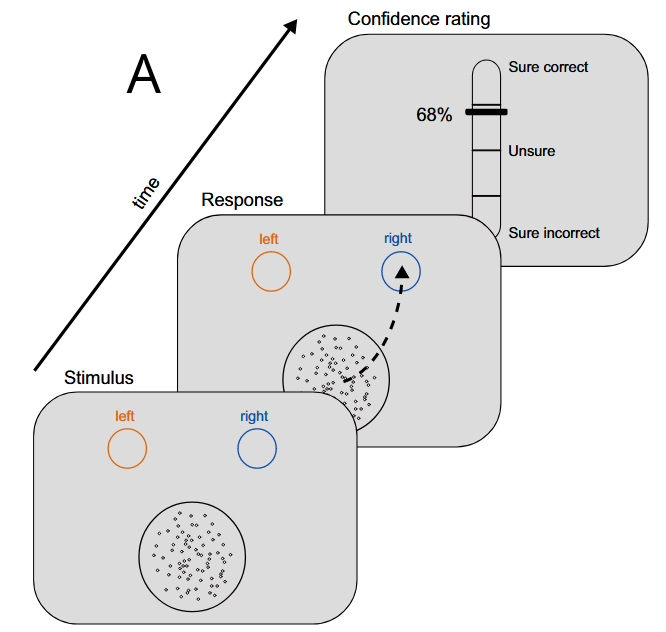

Dans cette tâche l'objectif est de décider si le mouvement d'un nuage de point est dirigé vers la droite ou vers la gauche. Ce mouvement est ambigü car le nuage contient un mélange de point bougeant vers la droite (par exemple 60% des points bougeant vers la droite et 40% vers la gauche si la bonne réponse est droite).

Chaque participants effectue de multiples essais, et pour chaque essai nous collectons

*   Si le participant à correctement répondu (accuracy)
*   Le temps écoulé entre la présentation du stimulus et l'initiation d'une réponse (RT)
*   La confiance du participant en sa décision (que nous allons ignorer aujourd'hui)



# Libraries and dependencies

In [ ]:
!pip install pyddm
import matplotlib.pyplot as plt
import pyddm
import pyddm.plot
from pyddm import Sample
import numpy as np
import pandas as pd
from pyddm import Model
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter, ICPoint, OverlayNone, BoundCollapsingExponential
from pyddm.functions import display_model
from pyddm import Fittable, Fitted
from pyddm import LossRobustLikelihood

# Loading data

In [ ]:
data = pd.read_csv("decision_data.csv", sep = ';')
data = data.loc[np.where(np.logical_and(data["reaction_time"]>=0.4,data["reaction_time"]<=2.5))[0]]
dec_data_sample = Sample.from_pandas_dataframe(data, rt_column_name="reaction_time", choice_column_name="correct")

data_copy = data.copy()
data_copy['stim_dir'] = data_copy['stim_dir'].replace(2,0)
data_copy['coherence'] = data_copy['coherence'].where(data_copy['stim_dir'] == 1, -data_copy['coherence'])
data_copy.reset_index()
choice = []
temp_cor = data_copy['correct'].to_numpy()
temp_side = data_copy['stim_dir'].to_numpy()
for i in range(0, len(temp_cor)):
  if temp_cor[i] == 1:
    choice.append(temp_side[i])
  if temp_cor[i] != 1 and temp_side[i] == 1:
    choice.append(0)
  if temp_cor[i] != 1 and temp_side[i] == 0:
    choice.append(1)

data_copy.insert(5, "choice", pd.Series(choice, index = data_copy.index))

dec_data_sample_stim = Sample.from_pandas_dataframe(
    data_copy,
    rt_column_name="reaction_time",
    choice_column_name="choice",
    choice_names=("left", "right"))

# Visualisation des données

Nos données sont contenues dans le dataframe "data", dont le contenu peut-être observé ci-dessous.

Comme nous nous intéréssons aux temps de réaction et à l'accuracy, nous allons visualiser ces deux quantités


In [ ]:
print(data)# Visualisation des données

In [ ]:
plt.hist(data['reaction_time'].to_numpy()[np.where(data["correct"]==1)[0]], bins = 100, color = 'g', label = 'correct')
plt.hist(data['reaction_time'].to_numpy()[np.where(data["correct"]==0)[0]], weights=-np.ones_like(data['reaction_time'].to_numpy()[np.where(data["correct"]==0)[0]]), bins = 100, color = 'r', label = 'error')
plt.legend()
plt.xlabel("Reaction Time")
plt.ylabel("Trial Count")
plt.title('Distribution of reaction times for correct and error trials')
plt.show()
print("Taux de réponses correctes : ", str(len(np.where(data['correct'] ==1)[0])/len(data['correct'])*100)+" %")

# Création d'un modèle simple

Pour continuer sur la lancée de la première partie du cours, nous allons maintenant créer notre premier modèle de diffusion.

Ce modèle comporte trois paramètres que vous pouvez manipuler pour observer leur effet.

In [ ]:
model_to_fit = Model(name='Simple model',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B=1.1),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.01, T_dur=2)
pyddm.plot.model_gui_jupyter(model_to_fit) #to use to give a quick analogy with data

### Questions :

*   Décrivez la figure (output du modèle), que représentent les deux courbes ?
*   Quels processus cognitifs représentent les différents paramètres de notre modèle?



## Observation d'essais uniques

Dans ce segment nous allons simuler des essais uniques et observers l'accumulation d'évidence en fonction du temps pour un modèle de diffusion. Ce modèle comporte deux paramètres additionnels par rapport au précédent, le bias et le seuil (bound)

Lorsque vous exécutez la cellule 10 essais sont simulés. Vous pouvez manipuler les différents paramètres du modèle avec les slider et ré-exécuter pour voir l'effet de votre manipulation.

In [ ]:
# @title Simulation de 10 essais individuels
plt.figure()

drift = 1 # @param {type:"slider", min:0, max:4, step:0.5}
noise = 2 # @param {type:"slider", min:0, max:4, step:0.5}
bound = 1 # @param {type:"slider", min:0, max:2, step:0.1}
bias = 0.5 # @param {type:"slider", min:0, max:0.9, step:0.1}

model = Model(name='Simple model',
              drift=DriftConstant(drift=drift),
              noise=NoiseConstant(noise=noise),
              bound=BoundConstant(B=1.1),
              IC = ICPoint(x0=bound - (bound*2*bias)),
              overlay=OverlayNonDecision(nondectime=.1),
              dx=.001, dt=.01, T_dur=2.5)
#model.show()

for i in range(0,10):
  trial = model.simulate_trial(seed=np.random.randint(0,1000))
  plt.plot(np.linspace(0,2.5, len(trial)), trial)
plt.axhline(bound, color='r', linestyle='--', label='Upper bound')
plt.axhline(-bound, color='b', linestyle='--', label='Lower bound')
plt.xlabel("Time (s)")
plt.ylabel("Evidence")
plt.title("Single-trial evidence accumulation")
plt.legend()
plt.show()

### Questions :

*   Décrivez la figure générée, a quoi correspondent chacunes des traces évoluant au court du temps?
*   A quels processus cognitifs correspondent nos nouveaux paramètres?
*   D'après ce que nous avons vu en cours, quel est l'étape suivante pour utiliser notre modèle pour analyser nos données?



# Fit du modèle : Modéliser les essais corrects et les erreurs

## Modèle Naïf

In [ ]:
m = Model(drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
            noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
            bound=BoundConstant(B=1.1),
            overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
            dx=.001, dt=.001, T_dur=2.5)

pyddm.plot.model_gui_jupyter(m, sample=dec_data_sample)


###Questions  :

*   Que représentent les lignes noires, et que représentent les histogrammes?
*   En manipulants les différents paramètres du modèle avec les sliders, décrire l'effet de vos manipulations et essayer de trouver le meilleurs ajustement possible aux données


## Ajustement automatique du modèle aux données

Nous allons maintenant utiliser une procédure d'ajustement automatique (cf CM1) aux données, pour trouver le jeu de paramètres (ou point dans l'espace de paramètres) pour lequel notre modèle représente le mieux nos données

In [ ]:
m.fit(sample=dec_data_sample, lossfunction = LossRobustLikelihood, verbose=False) # Set verbose=True to see fitting progress
print("Parameters:", m.parameters())

In [ ]:
pyddm.plot.plot_fit_diagnostics(model=m, sample=dec_data_sample)
plt.show()

### Question :

*   Comparez la sortie après ajustement du modèle aux paramètres que vous aviez trouvé à la question précédente. Comment votre ajustement manuel se compare-t-il à l'ajustement automatique?



## Comparaison du taux de réponse correcte entre le modèle et les données

Nous avons vu que notre modèle fait un travail acceptable pour prédire les temps de réaction, mais fait-il un bon travail pour prédire lorsque le participant répond correctement ou non?

In [ ]:
sol = m.solve()
pdf_corr = sol.pdf('correct')
dt = m.dt
accuracy = np.sum(pdf_corr) * dt * 100
print(f"Predicted accuracy: {accuracy:.3f}")
print("Observed accuracy : ", str(len(np.where(data['correct'] ==1)[0])/len(data['correct'])*100)+" %")


### Question :

*   Relancez plusieurs fois la procédure de fitting. Qu'observez-vous au niveau de l'accuracy prédite? Pourquoi?

# Prédire les temps de réactions en fonction du côté de réponse

Pour l'instant notre modèle prédit les temps de réaction et la probabilité de répondre correctement ou non.

Néanmoins nous pourrions souhaiter un modèle nous permettant de prédire non pas si le participant va répondre correctement ou non, mais s'il va répondre "droite" ou "gauche"

Nous pouvons visualiser la distribution des temps de réactions en fonction du côté de réponse en exécutant la cellule ci-dessous

## Visualisation des données

In [ ]:
plt.hist(data_copy['reaction_time'].to_numpy()[np.where(data_copy["choice"]==1)[0]], bins = 100, color = 'b', label = 'right')
plt.hist(data_copy['reaction_time'].to_numpy()[np.where(data_copy["choice"]==0)[0]], weights=-np.ones_like(data_copy['reaction_time'].to_numpy()[np.where(data_copy["choice"]==0)[0]]), bins = 100, color = 'gold', label = 'left')
plt.legend()
plt.xlabel("Reaction Time")
plt.ylabel("Trial Count")
plt.title('Distribution of reaction times for left and right trials')
plt.show()

### Question :

*   en quoi cet histogramme diffère-t-il de celui observé lorsque nous comparons les temps de réaction pour les essais corrects et incorrects? Pourquoi?



## Instantiation d'un nouveau modèle pour prédire le côté de réponse

Dans ce nouveau modèle nous définissons à nouveau deux seuils, l'un correspondant à la quantité d'évidence nécessaire pour déclencher la réponse 'droite', et l'autre pour déclencher la réponse 'gauche'.

Cela mis à part ce modèle posséde les mêmes paramètres que ceux vus précédemment

In [ ]:
model_stim = Model(drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
            noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
            bound=BoundConstant(B=1.1),
            overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
            choice_names=("left", "right"),
            dx=.001, dt=.01, T_dur=2.5)

pyddm.plot.model_gui_jupyter(model_stim, sample=dec_data_sample_stim)


###Questions  :

*   En manipulants les différents paramètres du modèle avec les sliders, essayer de trouver le meilleurs ajustement possible aux données

## Ajustement automatique du modèle

In [ ]:
model_stim.fit(sample=dec_data_sample_stim, lossfunction = LossRobustLikelihood, verbose=False)
print("Parameters:", model_stim.parameters())
pyddm.plot.plot_fit_diagnostics(model=model_stim, sample=dec_data_sample_stim)
plt.show()

### Question :

*   Comparez la sortie après ajustement du modèle aux paramètres que vous aviez trouvé à la question précédente. Comment votre ajustement manuel se compare-t-il à l'ajustement automatique?

## Améliorations du modèle

Nous avons maintenant un modèle permettant de prédire la proportion de réponse droite et gauche et les distributions des temps de réaction correspondants.


###Questions :

*   Que pensez-vous des performances du modèles, et quelles options pourriez-vous proposer pour essayer d'améliorer l'ajustement du modèle à nos données?


## Proposition de solution

### Ajustement manuel du modèle

In [ ]:
model_stim = Model(drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
            noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
            bound=BoundConstant(B=Fittable(minval=0.5, maxval=3)),
            overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
            choice_names=("left", "right"),
            dx=.001, dt=.001, T_dur=2.5)

pyddm.plot.model_gui_jupyter(model_stim, sample=dec_data_sample_stim)

###Questions :

*   Quelle différence observez-vous avec le précédent modèle?
*   Essayez de trouver manuellement le meilleur ensemble de paramètres.

### Ajustement automatique

In [ ]:
model_stim.fit(sample=dec_data_sample_stim,lossfunction = LossRobustLikelihood, verbose=False)
pyddm.plot.plot_fit_diagnostics(model=model_stim, sample=dec_data_sample_stim)

### Question :

*   Comparez la sortie après ajustement du modèle aux paramètres que vous aviez trouvé à la question précédente. Comment votre ajustement manuel se compare-t-il à l'ajustement automatique?

# Dilemne exploration/exploitation

Imaginons que nous placions nos participants dans une situation ou ils doivent prendre une décision le plus rapidement possible en un temps limité.

### Questions :


*   Quelle(s) modification(s) pourrions nous apporter au modèle pour prendre en compte cette contrainte?



In [ ]:
# @title Proposition de réponse

model_collapse = Model(name='test_collapse',
                   drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
                   noise=NoiseConstant(noise=1),
                   bound=BoundCollapsingExponential(B=Fittable(minval=0.5, maxval=3), tau=Fittable(minval=.0001, maxval=5)),
                   overlay=OverlayNonDecision(nondectime=.4),
                   choice_names=("left", "right"),
                   dx=.01, dt=.01, T_dur=2.5)

pyddm.plot.model_gui_jupyter(model_collapse, sample=dec_data_sample_stim)

## Effet de notre modification

In [ ]:
# @title Comparaison modèle classique et modèle avec collapsing boundaries
model_ex = Model(name='test_ex',
                   drift=DriftConstant(drift=(2)),
                   noise=NoiseConstant(noise=1),
                   bound=BoundCollapsingExponential(B=(2), tau=(0.7)),
                   overlay=OverlayNonDecision(nondectime=.1),
                   choice_names=("left", "right"),
                   dx=.01, dt=.01, T_dur=2.5)
model_classique = Model(name='test_classique',
                   drift=DriftConstant(drift=(2)),
                   noise=NoiseConstant(noise=1),
                   bound=BoundConstant(B=(2)),
                   overlay=OverlayNonDecision(nondectime=.1),
                   choice_names=("left", "right"),
                   dx=.01, dt=.01, T_dur=2.5)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,4), sharey = True)

for i in range(0,10):
  sim = model_classique.simulate_trial(seed=np.random.randint(0,1000))
  ax1.plot(np.linspace(0,2.5, len(sim)), sim)

for i in range(0,10):
  sim = model_ex.simulate_trial(seed=np.random.randint(0,1000))
  ax2.plot(np.linspace(0,2.5, len(sim)), sim)

time_points = np.linspace(0,2.5, len(sim))
upper_bound = np.array([BoundCollapsingExponential(B=model_ex.parameters()['bound']['B'], tau=model_ex.parameters()['bound']['tau']).get_bound(t) for t in time_points])
lower_bound = -upper_bound

ax2.plot(time_points, upper_bound, 'r--', label="Upper Bound")
ax2.plot(time_points, lower_bound, 'b--', label="Lower Bound")
ax2.legend()
ax1.plot(time_points, np.ones(len(time_points))+1, 'r--', label="Upper Bound")
ax1.plot(time_points, np.zeros(len(time_points))-2, 'b--', label="Lower Bound")
ax1.legend()
ax1.set_title("Modèle Classique")
ax2.set_title("Modèle avec Collapsing bounds")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax1.set_ylabel("Evidence")
ax2.set_ylabel("Evidence")
plt.title("Single-trial evidence accumulation")
plt.legend()
plt.show()

### Question :

*   Quelle serait l'impact du modèle avec collapsing bounds sur le comportement? Comment celà connecte-t-il avec la notion de pression temporelle?
* Quelle autre ajustement d'un paramètre au cours du temps aurait pu avoir un effet similaire?

### Ajustement automatique à nos données

In [ ]:
model_collapse.fit(sample=dec_data_sample_stim,lossfunction = LossRobustLikelihood, verbose=False)
pyddm.plot.plot_fit_diagnostics(model=model_collapse, sample=dec_data_sample_stim)

### Question :

*   Est-ce que cette manipulation améliore significativement les performances de notre modèle selon vous? Pourquoi? Vous pouvez vous aidez de l'ouptut de la cellule suivante pour répondre à cette question



## Visualisation des collapsing boundaries

In [ ]:
for i in range(0,10):
  sim = model_collapse.simulate_trial(seed=np.random.randint(0,1000))
  plt.plot(np.linspace(0,2.5, len(sim)), sim)

time_points = np.linspace(0,2.5, len(sim))
upper_bound = np.array([BoundCollapsingExponential(B=model_collapse.parameters()['bound']['B'], tau=model_collapse.parameters()['bound']['tau']).get_bound(t) for t in time_points])
lower_bound = -upper_bound

plt.plot(time_points, upper_bound, 'r--', label="Upper Bound")
plt.plot(time_points, lower_bound, 'b--', label="Lower Bound")
plt.xlabel("Time (s)")
plt.ylabel("Evidence")
plt.legend()
plt.show()

# Bonus : Ajout d'un paramètre leak.

In [ ]:
# @title Simulation de 10 essais individuels avec un modèle classique
plt.figure()

drift = 0 # @param {type:"slider", min:0, max:4, step:0.5}
noise = 2.5 # @param {type:"slider", min:0, max:4, step:0.5}
bound = 1 # @param {type:"slider", min:0, max:2, step:0.1}
bias = 0.2 # @param {type:"slider", min:0, max:0.9, step:0.1}

model = Model(name='Simple model',
              drift=DriftConstant(drift=drift),
              noise=NoiseConstant(noise=noise),
              bound=BoundConstant(B=1.1),
              IC = ICPoint(x0=bound - (bound*2*bias)),
              overlay=OverlayNonDecision(nondectime=.1),
              dx=.001, dt=.01, T_dur=2.5)
#model.show()

for i in range(0,10):
  trial = model.simulate_trial(seed=np.random.randint(0,1000))
  plt.plot(np.linspace(0,2.5, len(trial)), trial)
plt.axhline(bound, color='r', linestyle='--', label='Upper bound')
plt.axhline(-bound, color='b', linestyle='--', label='Lower bound')
plt.xlabel("Time (s)")
plt.ylabel("Evidence")
plt.title("Single-trial evidence accumulation")
plt.legend()
plt.show()

### Questions


*   Avec le modèle ci-dessus, qu'observez-vous lorsque vous placez le drift à 0 en fonction des différentes valeurs du paramètre noise?
* Selon vous quelle est la cause de cette observation?
* Quelle problématique peut en émerger?
* Quelle solution pourriez-vous proposer?



In [ ]:
from pyddm.models import OverlayChain, OverlayPoissonMixture
class DriftCoherenceLeak(pyddm.models.Drift):
    name = "Leaky drift depends linearly on coherence"
    required_parameters = ["driftcoh", "leak"] # <-- Parameters we want to include in the model
    required_conditions = ["coherence"] # <-- Task parameters ("conditions"). Should be the same name as in the sample.

    # We must always define the get_drift function, which is used to compute the instantaneous value of drift.
    def get_drift(self, x, conditions, **kwargs):
        return self.driftcoh * conditions['coherence'] + self.leak * x

from pyddm.models import BoundCollapsingExponential

model_leak = Model(name='test_leaky',
                   drift=DriftCoherenceLeak(driftcoh=Fittable(minval=0, maxval=20), leak=Fittable(minval=-10, maxval=10)),
                   noise=NoiseConstant(noise=1),
                   bound=BoundConstant(B=Fittable(minval=0.5, maxval=3)),
                   overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),OverlayPoissonMixture(pmixturecoef=.02, rate=1)]),
                   choice_names=("left", "right"),
                   dx=.01, dt=.01, T_dur=2.5)

pyddm.plot.model_gui_jupyter(model_leak, sample=dec_data_sample_stim)

In [ ]:
model_leak.fit(sample=dec_data_sample_stim, verbose=False)
pyddm.plot.plot_fit_diagnostics(model=model_leak, sample=dec_data_sample_stim)